# Import data

In [6]:
import pandas as pd
import numpy as np
sales=pd.read_csv("data_processed.csv")
sales

,week,sku,weekly_sales,price,price-1,price-2,feat_main_page,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,functionality_02.Portable smartphone chargers,functionality_03.Bluetooth speakers,functionality_04.Selfie sticks,functionality_05.Bluetooth tracker,functionality_06.Mobile phone accessories,functionality_07.Headphones,functionality_08.Digital pencils,functionality_09.Smartphone stands,functionality_10.VR headset,functionality_11.Fitness trackers,functionality_12.Flash drives,color_blue,color_gold,color_green,color_grey,color_none,color_pink,color_purple,color_red,color_white,vendor_2,vendor_3,vendor_4,vendor_5,vendor_6,vendor_7,vendor_8,vendor_9,vendor_10
0,2016-11-14,1,110.0,10.24,9.86,10.16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2016-11-21,1,127.0,8.27,10.24,9.86,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,2016-11-28,1,84.0,8.83,8.27,10.24,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2016-12-05,1,87.0,8.98,8.83,8.27,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,2016-12-12,1,64.0,10.40,8.98,8.83,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,2018-08-27,44,20.0,53.99,42.38,43.99,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4308,2018-09-03,44,14.0,52.99,53.99,42.38,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4309,2018-09-10,44,22.0,44.99,52.99,53.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4310,2018-09-17,44,28.0,42.99,44.99,52.99,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [7]:
res=pd.DataFrame(index=['R2'])
res

""
R2


# III/ Tree-based methods

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
## Structure by SKU ##
skuSet = list(sales.sku.unique())
skuData = {}
colnames = [i for i in sales.columns if i not in ["week","weekly_sales","sku"] ]
for i in skuSet:
  df_i = sales[sales.sku == i]
  skuData[i] = {'X': df_i[colnames].values,
                'y': df_i.weekly_sales.values}

## Decentralized Structure ##
X_dict = {}
y_dict = {}

skuModels = {}
y_pred = []
y_test = []
y_train = []

for i in skuSet:
  
  X_train_i,X_test_i = np.split(skuData[i]["X"], [68]) #split for X
  y_train_i,y_test_i = np.split(skuData[i]["y"], [68]) #split for y 

  X_dict[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict[i] = {'train': y_train_i, 'test': y_test_i}

  y_test += list(y_test_i) #creating the complete training array
  y_train += list(y_train_i) #creating the complete testing array

## Centralized Structure ##
X_cen_train = X_dict[skuSet[0]]['train'] #initialization with item 0
X_cen_test = X_dict[skuSet[0]]['test']

for i in skuSet[1:]: #Iteration over items
    X_cen_train = np.concatenate((X_cen_train, X_dict[i]['train']), axis = 0) #Bringing together the training set
    X_cen_test = np.concatenate((X_cen_test, X_dict[i]['test']), axis = 0)

## 1) Decision tree

### a) Centralized Decision Tree

#### i) Selection of optimal parameters

***Process:***
We split the training set into two subsets (e.g., by using a time-based split so as to keep the temporal structure of the data). The training set is split between a training subset and a testing subset (often called a validation test). The models are trained on the training subset and the testing subset is used to select the parameters. Once the parameters are selected, we can train the final model using the entire training set and record the performance on the test set. An illustration of this procedure is presented below.


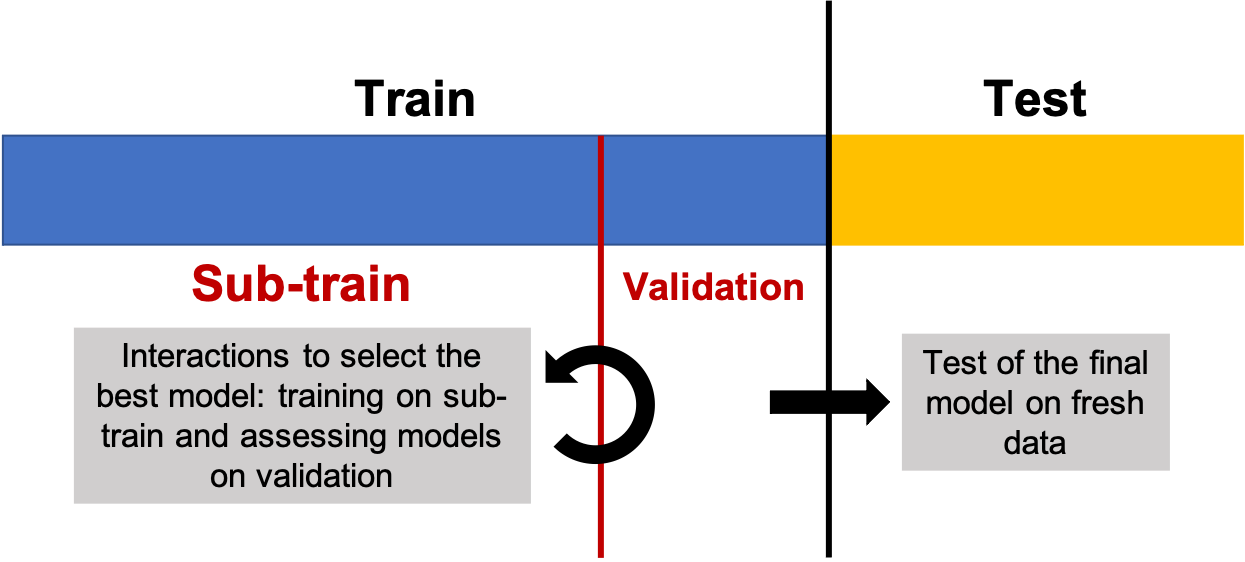

Build subsets:

In [10]:
X_dict_subsplit = {} 
y_dict_subsplit = {} 

y_validation = [] 
y_subtrain = [] 

for i in skuSet:

  X_train_i,X_test_i = np.split(X_dict[i]["train"], [48]) #split for X
  y_train_i,y_test_i = np.split(y_dict[i]["train"], [48]) #split for y 

  X_dict_subsplit[i] = {'train': X_train_i, 'test': X_test_i} #filling dictionary
  y_dict_subsplit[i] = {'train': y_train_i, 'test': y_test_i}

  y_validation += list(y_test_i) #creating the complete training array
  y_subtrain += list(y_train_i) #creating the complete testing array

Structure centralized data:

In [11]:
X_cen_subtrain = X_dict_subsplit[skuSet[0]]['train'] #initialization with item 0 #X_cen_train_sub
X_cen_validation = X_dict_subsplit[skuSet[0]]['test'] #X_cen_test_sub

for i in skuSet[1:]: #Iteration over items
    X_cen_subtrain = np.concatenate((X_cen_subtrain, X_dict_subsplit[i]['train']), axis = 0) #Bringing together the training set
    X_cen_validation = np.concatenate((X_cen_validation, X_dict_subsplit[i]['test']), axis = 0)

Iterations to select the best model and test on fresh data:

In [12]:
import random
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score

max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)

## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  print('  Parameters:',[mf,md])
  #model
  DT_cen = DecisionTreeRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_cen_subtrain, y_subtrain)
  score=r2_score(y_validation, DT_cen.predict(X_cen_validation))
  print('  R2:',score)
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md]
    maximum_score = score

## Test on fresh data
mf,md=params
DT_cen = DecisionTreeRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_cen_train, y_train)
oos_r2=r2_score(y_test, DT_cen.predict(X_cen_test))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)  

Model number: 1
  Parameters: [28, 4]
  R2: 0.4935524083441645
Model number: 2
  Parameters: [33, 4]
  R2: 0.5455785558415658
Model number: 3
  Parameters: [36, 8]
  R2: 0.39950317598797336
Model number: 4
  Parameters: [42, 5]
  R2: 0.37703540782093925
Model number: 5
  Parameters: [33, 4]
  R2: 0.5455785558415658
Model number: 6
  Parameters: [41, 5]
  R2: 0.3774997531448644
Model number: 7
  Parameters: [3, 7]
  R2: 0.022636226270612236
Model number: 8
  Parameters: [22, 2]
  R2: 0.3442076648424248
Model number: 9
  Parameters: [42, 9]
  R2: 0.3278105144531882
Model number: 10
  Parameters: [29, 2]
  R2: 0.4594523462029316
Model number: 11
  Parameters: [40, 7]
  R2: 0.3774275210481671
Model number: 12
  Parameters: [6, 8]
  R2: -0.03805039452618808
Model number: 13
  Parameters: [22, 2]
  R2: 0.3442076648424248
Model number: 14
  Parameters: [12, 8]
  R2: 0.4699426024312624
Model number: 15
  Parameters: [25, 4]
  R2: 0.5435336100474423
Model number: 16
  Parameters: [26, 6]
  R2: 

#### ii) Final model

In [13]:
import time

tZero=time.time()

DT_cen = DecisionTreeRegressor(max_features=17,max_depth=4,random_state=0).fit(X_cen_train, y_train)
print('OOS R2:',round(r2_score(y_test, DT_cen.predict(X_cen_test)),3))

t = time.time()-tZero
print("Time to compute:",round(t,3)," sec")

res['centralized-DT']=[r2_score(y_test, DT_cen.predict(X_cen_test))]

OOS R2: 0.159
Time to compute: 0.009  sec


#### iii) Example of a plotted tree

In [14]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [15]:
DT_cen_visualization = DecisionTreeRegressor(max_features=43,max_depth=3,random_state=0).fit(X_cen_train, y_train)
print('OOS R2:',round(r2_score(y_test, DT_cen_visualization.predict(X_cen_test)),3))

OOS R2: 0.118


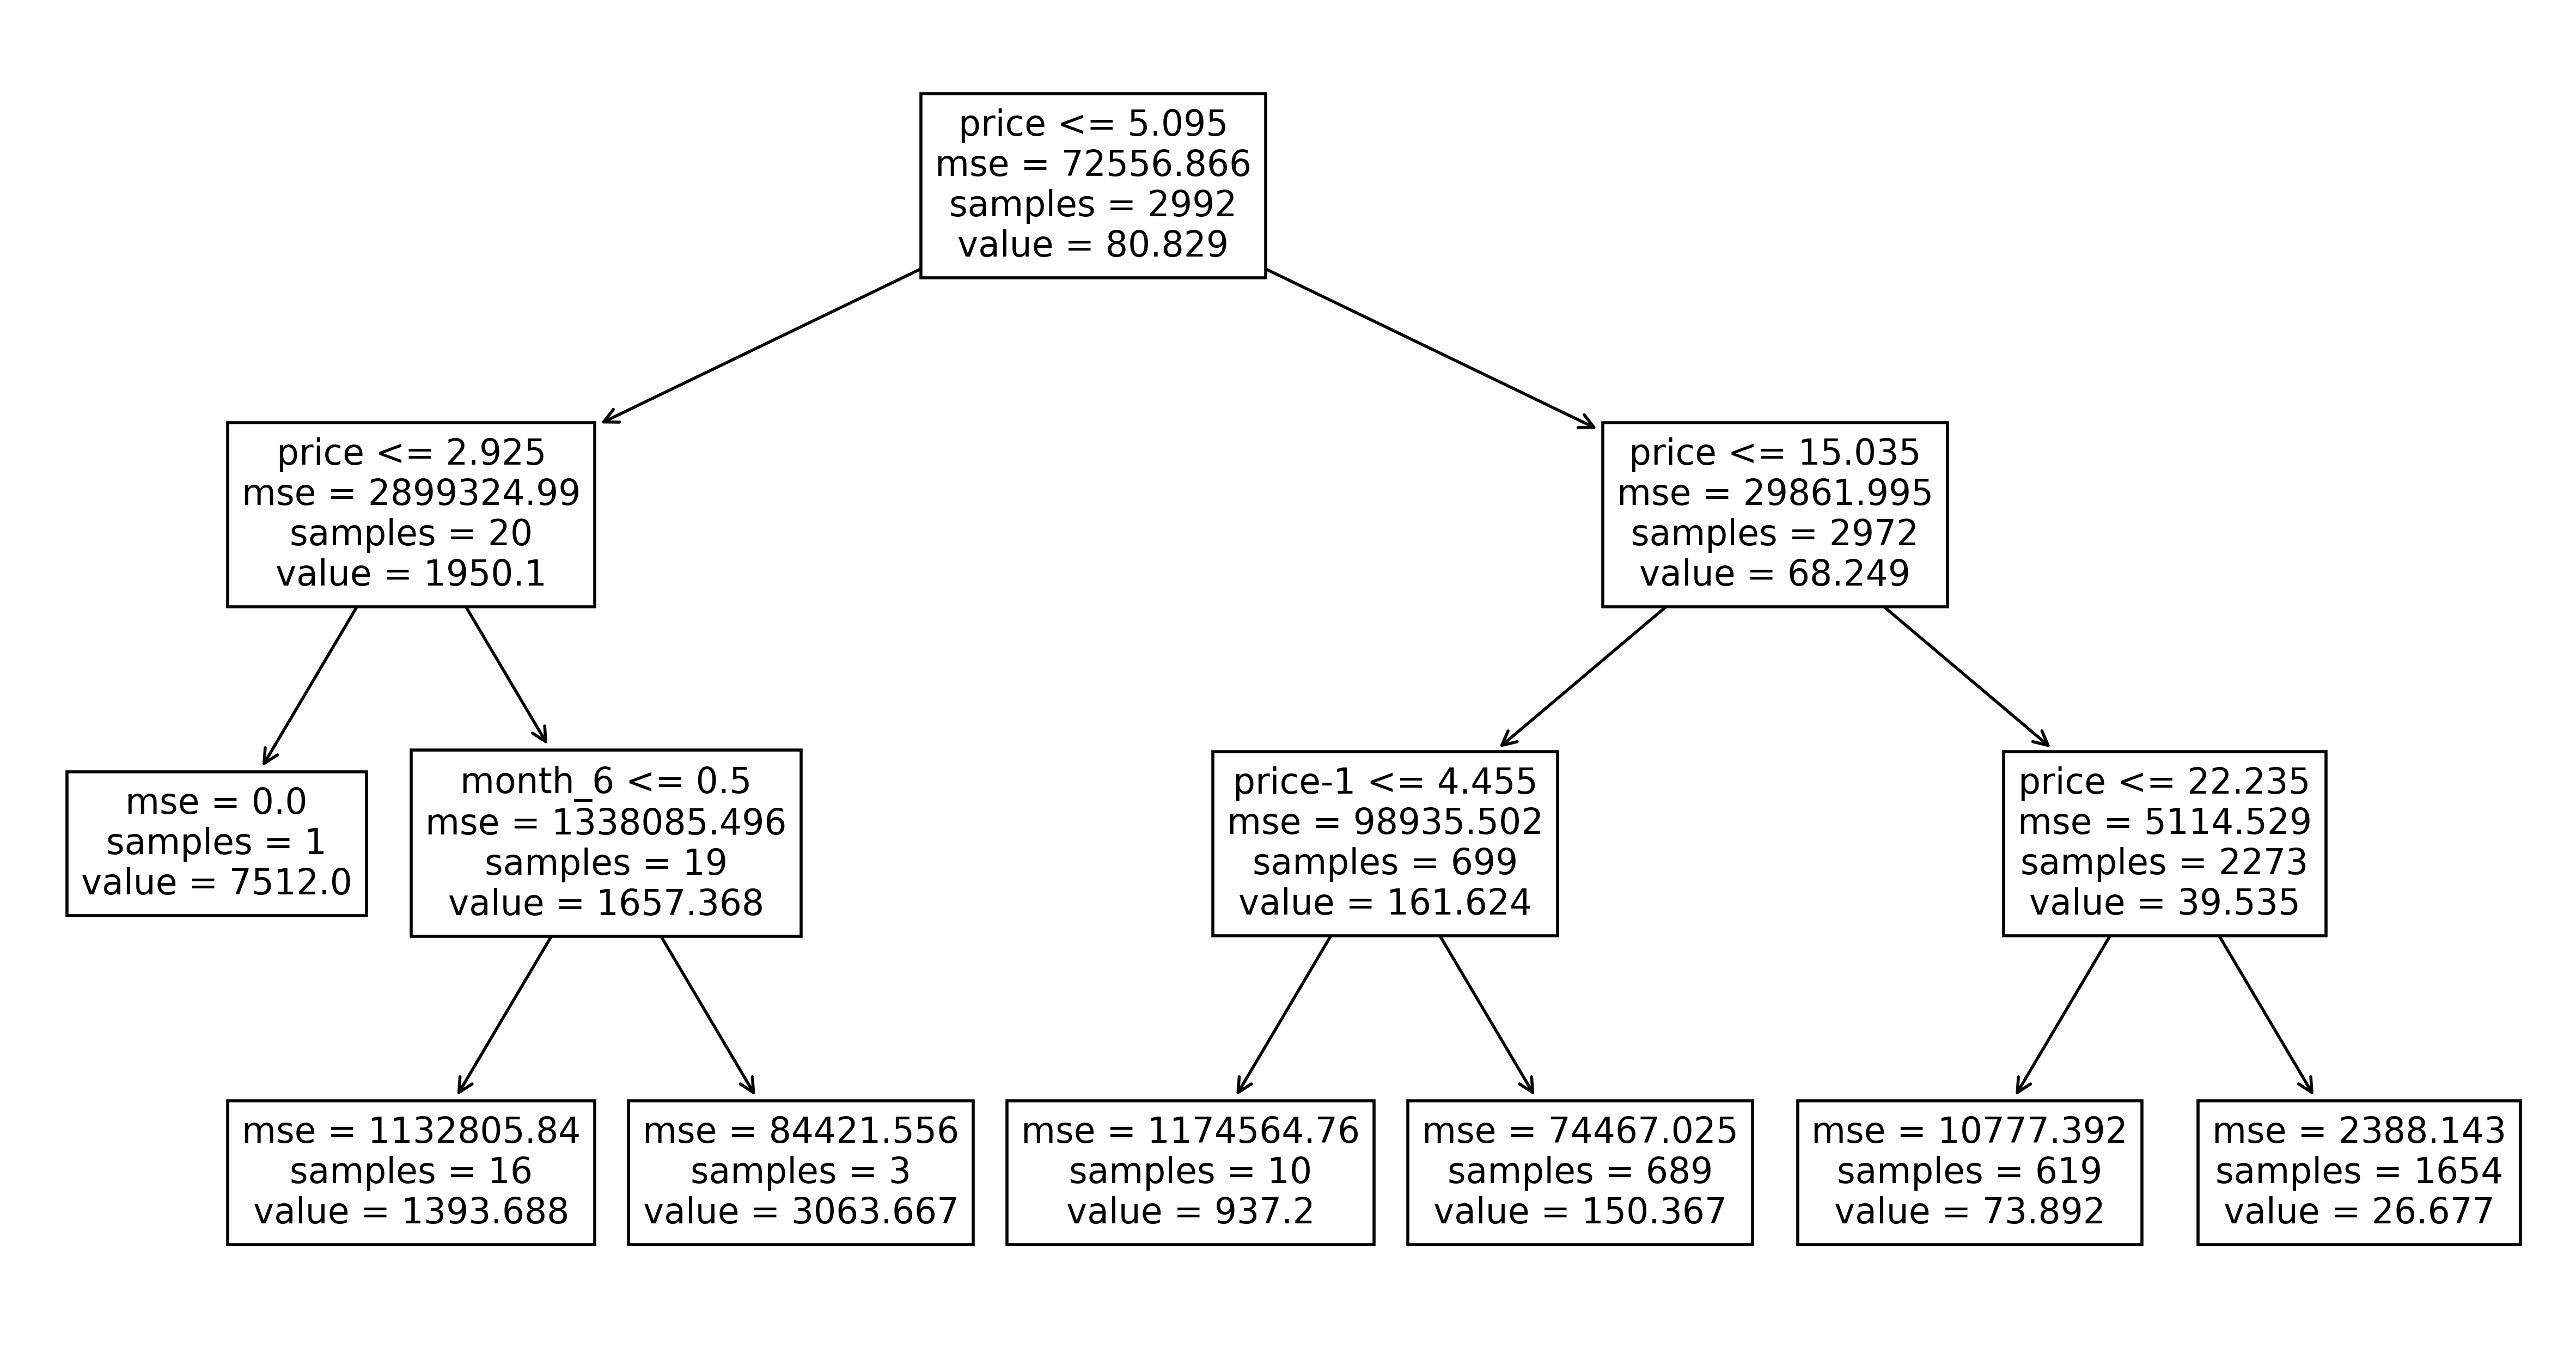

In [16]:
## Plot
plt.figure(figsize=(15,8), dpi=400)
plot_tree(DT_cen_visualization, feature_names = colnames)
plt.savefig("visualization_decision_tree.png", bbox_inches='tight')
plt.show()

### b) Decentralized Decision Tree

Selection of the best model:

In [17]:
max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)

## Selection of the best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  print('  Parameters:',[mf,md])
  #model
  y_pred = []
  for i in skuSet:
      model_i = DecisionTreeRegressor(max_features=mf,max_depth=md,random_state=0).fit(X_dict_subsplit[i]['train'] , y_dict_subsplit[i]['train'])
      y_pred += list(model_i.predict(X_dict_subsplit[i]['test']))
  score=r2_score(y_validation, np.array(y_pred))
  #compare performances on validation data
  if score>maximum_score:
    params = [mf,md]
    maximum_score = score

## Test on fresh data
mf,md=params
y_pred = []
for i in skuSet:
    model_i = DecisionTreeRegressor(max_features=mf,max_depth=md,random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
    y_pred += list(model_i.predict(X_dict[i]['test']))
oos_r2=r2_score(y_test, np.array(y_pred))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)

Model number: 1
  Parameters: [28, 4]
Model number: 2
  Parameters: [33, 4]
Model number: 3
  Parameters: [36, 8]
Model number: 4
  Parameters: [42, 5]
Model number: 5
  Parameters: [33, 4]
Model number: 6
  Parameters: [41, 5]
Model number: 7
  Parameters: [3, 7]
Model number: 8
  Parameters: [22, 2]
Model number: 9
  Parameters: [42, 9]
Model number: 10
  Parameters: [29, 2]
Model number: 11
  Parameters: [40, 7]
Model number: 12
  Parameters: [6, 8]
Model number: 13
  Parameters: [22, 2]
Model number: 14
  Parameters: [12, 8]
Model number: 15
  Parameters: [25, 4]
Model number: 16
  Parameters: [26, 6]
Model number: 17
  Parameters: [2, 2]
Model number: 18
  Parameters: [11, 2]
Model number: 19
  Parameters: [14, 3]
Model number: 20
  Parameters: [41, 9]
Model number: 21
  Parameters: [34, 3]
Model number: 22
  Parameters: [8, 8]
Model number: 23
  Parameters: [36, 9]
Model number: 24
  Parameters: [7, 9]
Model number: 25
  Parameters: [28, 4]
Model number: 26
  Parameters: [7, 4]
M

Final model:

In [18]:
tZero=time.time()

y_pred = []
for i in skuSet:
    model_i = DecisionTreeRegressor(max_features=14, max_depth=4, random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
    y_pred += list(model_i.predict(X_dict[i]['test']))

print('OOS R2:',round(r2_score(y_test, np.array(y_pred)),3))

t = time.time()-tZero
print("Time to compute:",round(t,3)," sec")


OOS R2: 0.399
Time to compute: 0.037  sec


## 2) Random forest

### a) Centralized Random Forest

Selection of the best model:

In [19]:
from sklearn.ensemble import RandomForestRegressor

max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)

## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  #ne = ne_[i]
  print('  Parameters:',[mf, md])
  #model
  RF_cen = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_cen_subtrain, y_subtrain)
  score=r2_score(y_validation, RF_cen.predict(X_cen_validation))
  print('  R2:',score)
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md]
    maximum_score = score

## Test on fresh data
mf,md=params
RF_cen = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_cen_train, y_train)
oos_r2=r2_score(y_test, RF_cen.predict(X_cen_test))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)  

Model number: 1
  Parameters: [28, 4]
  R2: 0.4461114933493536
Model number: 2
  Parameters: [33, 4]
  R2: 0.43762197175744033
Model number: 3
  Parameters: [36, 8]
  R2: 0.43172929379344194
Model number: 4
  Parameters: [42, 5]
  R2: 0.44694973016153594
Model number: 5
  Parameters: [33, 4]
  R2: 0.43762197175744033
Model number: 6
  Parameters: [41, 5]
  R2: 0.4361335978630835
Model number: 7
  Parameters: [3, 7]
  R2: 0.2309302683216674
Model number: 8
  Parameters: [22, 2]
  R2: 0.3527259359598842
Model number: 9
  Parameters: [42, 9]
  R2: 0.4046187195722295
Model number: 10
  Parameters: [29, 2]
  R2: 0.3787883619741803
Model number: 11
  Parameters: [40, 7]
  R2: 0.40882491460356885
Model number: 12
  Parameters: [6, 8]
  R2: 0.3063979127249076
Model number: 13
  Parameters: [22, 2]
  R2: 0.3527259359598842
Model number: 14
  Parameters: [12, 8]
  R2: 0.33522842562118815
Model number: 15
  Parameters: [25, 4]
  R2: 0.4278402674128151
Model number: 16
  Parameters: [26, 6]
  R2: 

Final model:

In [20]:
tZero=time.time()

RF_cen = RandomForestRegressor(max_features=31, 
                               max_depth=4, 
                               random_state=0).fit(X_cen_train, y_train)

print('OOS R2:',round(r2_score(y_test, RF_cen.predict(X_cen_test)),3))

t = time.time()-tZero
print("Time to compute:",round(t,3)," sec")

res['centralized-RF']=[r2_score(y_test, RF_cen.predict(X_cen_test))]

OOS R2: 0.272
Time to compute: 0.413  sec


### b) Decentralized Random Forest

Selection of the best model:

In [21]:
max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)

## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  print('  Parameters:',[mf,md])
  #model
  y_pred = []
  for i in skuSet:
    model_i = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_dict_subsplit[i]['train'] , y_dict_subsplit[i]['train'])
    y_pred += list(model_i.predict(X_dict_subsplit[i]['test']))
  score=r2_score(y_validation, np.array(y_pred))
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md]
    maximum_score = score

## Test on fresh data
mf,md=params
y_pred = []
for i in skuSet:
  model_i = RandomForestRegressor(max_features=mf, max_depth=md, random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
  y_pred += list(model_i.predict(X_dict[i]['test']))
oos_r2=r2_score(y_test, np.array(y_pred))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)  

Model number: 1
  Parameters: [28, 4]
Model number: 2
  Parameters: [33, 4]
Model number: 3
  Parameters: [36, 8]
Model number: 4
  Parameters: [42, 5]
Model number: 5
  Parameters: [33, 4]
Model number: 6
  Parameters: [41, 5]
Model number: 7
  Parameters: [3, 7]
Model number: 8
  Parameters: [22, 2]
Model number: 9
  Parameters: [42, 9]
Model number: 10
  Parameters: [29, 2]
Model number: 11
  Parameters: [40, 7]
Model number: 12
  Parameters: [6, 8]
Model number: 13
  Parameters: [22, 2]
Model number: 14
  Parameters: [12, 8]
Model number: 15
  Parameters: [25, 4]
Model number: 16
  Parameters: [26, 6]
Model number: 17
  Parameters: [2, 2]
Model number: 18
  Parameters: [11, 2]
Model number: 19
  Parameters: [14, 3]
Model number: 20
  Parameters: [41, 9]
Model number: 21
  Parameters: [34, 3]
Model number: 22
  Parameters: [8, 8]
Model number: 23
  Parameters: [36, 9]
Model number: 24
  Parameters: [7, 9]
Model number: 25
  Parameters: [28, 4]
Model number: 26
  Parameters: [7, 4]
M

Final model:

In [22]:
tZero=time.time()

y_pred = []
for i in skuSet:
  model_i = RandomForestRegressor(max_features=44,
                                  max_depth=8,
                                  random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
  y_pred += list(model_i.predict(X_dict[i]['test']))

print('OOS R2:',round(r2_score(y_test, np.array(y_pred)),3))

t = time.time()-tZero
print("Time to compute:",round(t,3)," sec")

res['decentralized-RF']=[r2_score(y_test, np.array(y_pred))]

OOS R2: 0.559
Time to compute: 5.811  sec


## 3) Gradient Boosting

### a) Centralized Gradient Boosting

Selection of best model:

In [23]:
max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
learning_rate_ = [0.01, 0.05, 0.1, 0.5]
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)
lr_ = random.choices(learning_rate_, k=50)

from sklearn.ensemble import GradientBoostingRegressor
## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  lr = lr_[i]
  print('  Parameters:',[mf,md,lr])
  #model
  GB_cen = GradientBoostingRegressor(max_features=mf,
                                     max_depth=md,
                                     learning_rate=lr,
                                     random_state=0).fit(X_cen_subtrain, y_subtrain)
  score=r2_score(y_validation, GB_cen.predict(X_cen_validation))
  print('  R2:',score)
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md,lr]
    maximum_score = score

## Test on fresh data
mf,md,lr=params
GB_cen = GradientBoostingRegressor(max_features=mf,
                                   max_depth=md,
                                   learning_rate=lr,
                                   random_state=0).fit(X_cen_train, y_train)
oos_r2=r2_score(y_test, GB_cen.predict(X_cen_test))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2)  

Model number: 1
  Parameters: [28, 4, 0.5]
  R2: 0.3055549921328825
Model number: 2
  Parameters: [33, 4, 0.1]
  R2: 0.33940405652189787
Model number: 3
  Parameters: [36, 8, 0.05]
  R2: 0.44406289854215597
Model number: 4
  Parameters: [42, 5, 0.01]
  R2: 0.33691057809570635
Model number: 5
  Parameters: [33, 4, 0.1]
  R2: 0.33940405652189787
Model number: 6
  Parameters: [41, 5, 0.5]
  R2: 0.33314531459257735
Model number: 7
  Parameters: [3, 7, 0.05]
  R2: 0.28978365166976205
Model number: 8
  Parameters: [22, 2, 0.05]
  R2: 0.4139858489603272
Model number: 9
  Parameters: [42, 9, 0.01]
  R2: 0.34293538907109455
Model number: 10
  Parameters: [29, 2, 0.5]
  R2: 0.4114928775273895
Model number: 11
  Parameters: [40, 7, 0.01]
  R2: 0.34990031799724175
Model number: 12
  Parameters: [6, 8, 0.05]
  R2: 0.29572302874045675
Model number: 13
  Parameters: [22, 2, 0.5]
  R2: 0.3317069310446841
Model number: 14
  Parameters: [12, 8, 0.01]
  R2: 0.2809925411708557
Model number: 15
  Parameter

Final model:

In [24]:
tZero=time.time()

GB_cen = GradientBoostingRegressor(max_features=14,
                                   max_depth=7,
                                   learning_rate=0.5,
                                   random_state=0).fit(X_cen_train, y_train)

print('OOS R2:',round(r2_score(y_test, GB_cen.predict(X_cen_test)),3))

t = time.time()-tZero
print("Time to compute:",round(t,3),"sec")

res['centralized-GB']=[r2_score(y_test, GB_cen.predict(X_cen_test))]

OOS R2: 0.223
Time to compute: 0.38 sec


### b) Decentralized Gradient Boosting

Selection of best model:

In [25]:
max_features_ = list(range(2,45)) 
max_depth_ = list(range(2,10))
learning_rate_ = [0.01, 0.05, 0.1, 0.5]
params=[]
maximum_score=0

#selection of parameters to test
random.seed(5)
mf_ = random.choices(max_features_, k=50)
md_ = random.choices(max_depth_, k=50)
lr_ = random.choices(learning_rate_, k=50)

## Iterations to select best model
for i in range (50):
  print('Model number:',i+1)
  #selection of parameters to test
  mf = mf_[i]
  md = md_[i]
  lr = lr_[i]
  print('  Parameters:',[mf,md,lr])
  #model
  y_pred = []
  for i in skuSet:
    model_i = GradientBoostingRegressor(max_features=mf,
                                        max_depth=md,
                                        learning_rate=lr,
                                        random_state=0).fit(X_dict_subsplit[i]['train'] , y_dict_subsplit[i]['train'])
    y_pred += list(model_i.predict(X_dict_subsplit[i]['test']))
  score=r2_score(y_validation, np.array(y_pred))
  print('  R2:',score)
  #compare performances on validation data
  if score > maximum_score:
    params = [mf,md,lr]
    maximum_score = score

## Test on fresh data
mf,md,lr=params
y_pred = []
for i in skuSet:
  model_i = GradientBoostingRegressor(max_features=mf,
                                      max_depth=md,
                                      learning_rate=lr,
                                      random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
  y_pred += list(model_i.predict(X_dict[i]['test']))
oos_r2=r2_score(y_test, np.array(y_pred))

print('\nBest Model:')
print('Parameters:',params)
print('Validation R2:',maximum_score)
print('OOS R2:', oos_r2) 

Model number: 1
  Parameters: [28, 4, 0.5]
  R2: 0.41664273866140356
Model number: 2
  Parameters: [33, 4, 0.1]
  R2: 0.442208320708552
Model number: 3
  Parameters: [36, 8, 0.05]
  R2: 0.4358179584071642
Model number: 4
  Parameters: [42, 5, 0.01]
  R2: 0.36258698473253514
Model number: 5
  Parameters: [33, 4, 0.1]
  R2: 0.442208320708552
Model number: 6
  Parameters: [41, 5, 0.5]
  R2: 0.4619031200543795
Model number: 7
  Parameters: [3, 7, 0.05]
  R2: 0.23286608554645838
Model number: 8
  Parameters: [22, 2, 0.05]
  R2: 0.3554789148712222
Model number: 9
  Parameters: [42, 9, 0.01]
  R2: 0.34684547617056705
Model number: 10
  Parameters: [29, 2, 0.5]
  R2: 0.4973757468051202
Model number: 11
  Parameters: [40, 7, 0.01]
  R2: 0.33907759941584414
Model number: 12
  Parameters: [6, 8, 0.05]
  R2: 0.2802951196453799
Model number: 13
  Parameters: [22, 2, 0.5]
  R2: 0.5663441850269925
Model number: 14
  Parameters: [12, 8, 0.01]
  R2: 0.2619938250174748
Model number: 15
  Parameters: [25

In [26]:
tZero=time.time()
y_pred = []
for i in skuSet:
    model_i = GradientBoostingRegressor(max_features=31,
                                        max_depth=4,
                                        learning_rate=0.5,
                                        random_state=0).fit(X_dict[i]['train'] , y_dict[i]['train'])
    y_pred += list(model_i.predict(X_dict[i]['test']))

print('OOS R2:',round(r2_score(y_test, np.array(y_pred)),3))


t = time.time()-tZero
print("Time to compute:",round(t,3)," sec")

res['decentralized-GB']=[r2_score(y_test, np.array(y_pred))]

OOS R2: 0.497
Time to compute: 1.421  sec


In [27]:
res

,centralized-DT,centralized-RF,decentralized-RF,centralized-GB,decentralized-GB
R2,0.159197,0.272476,0.558817,0.222851,0.496599
